# 1. Import and Install Dependencies
# 1.1 Install Dependencies

In [ ]:
!pip install tensorflow_io==0.23.0
import tensorflow_io as tfio

In [ ]:
!pip install opendatasets

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1

In [5]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import opendatasets as od

# Dawnload files

In [ ]:
od.download("https://www.kaggle.com/datasets/kenjee/z-by-hp-unlocked-challenge-3-signal-processing")

In [7]:
voi_file = os.path.join("/content/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC114131-0.wav")
voi_file_no = os.path.join("/content/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/Crickets-chirping-1.wav")

In [8]:
voi_file

'/content/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC114131-0.wav'

In [9]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
wave = load_wav_16k_mono(voi_file)
nwave = load_wav_16k_mono(voi_file_no)

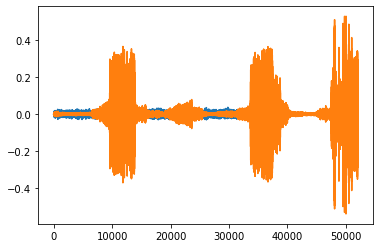

In [11]:
plt.plot(wave)
plt.plot(nwave)
plt.show()
#the blue is for capuchin bird and the orange one for not capuchin

# Transforming the waves into spectogram
- What is a spectrogram in audio?
A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform

# 3. Create Tensorflow Dataset

# 3.1 Define Paths to Positive and Negative Data

In [12]:
POS = os.path.join("/content/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips")
NEG = os.path.join("/content/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips")

# 3.2 Create Tensorflow Datasets

In [13]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [14]:
#so we just have the path of the files
pos.as_numpy_iterator().next()

b'/content/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC3776-5.wav'

# 3.3 Add labels and Combine Positive and Negative Samples

In [15]:
#this just gonna put label for each voi, if it is pos then it's label gonna be one else zero
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [16]:
data.shuffle(1000).as_numpy_iterator().next()

(b'/content/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/rain-thunder-and-crickets-sound-effect-43.wav',
 0.0)

# 4. Determine Average Length of a Capuchin Call

# 4.1 Calculate Wave Cycle Length 

In [ ]:
lengths = []
for file in os.listdir("/content/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips"):
    tensor_wave = load_wav_16k_mono(os.path.join("/content/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips", file))
    lengths.append(len(tensor_wave))

# 4.2 Calculate Mean, Min and Max

In [18]:
#so the mean is about 54156 waves so with 16000 H --- 
print(tf.math.reduce_mean(lengths))
print(tf.math.reduce_min(lengths))
print(tf.math.reduce_max(lengths))

tf.Tensor(54156, shape=(), dtype=int32)
tf.Tensor(32000, shape=(), dtype=int32)
tf.Tensor(80000, shape=(), dtype=int32)


# 5. Build Preprocessing Function to Convert to Spectrogram
# 5.1 Build Preprocessing Function

In [19]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    #it give us short time  fourier transform  
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    #remove the negative
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

# 5.2 Test Out the Function and Viz the Spectrogram

In [ ]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

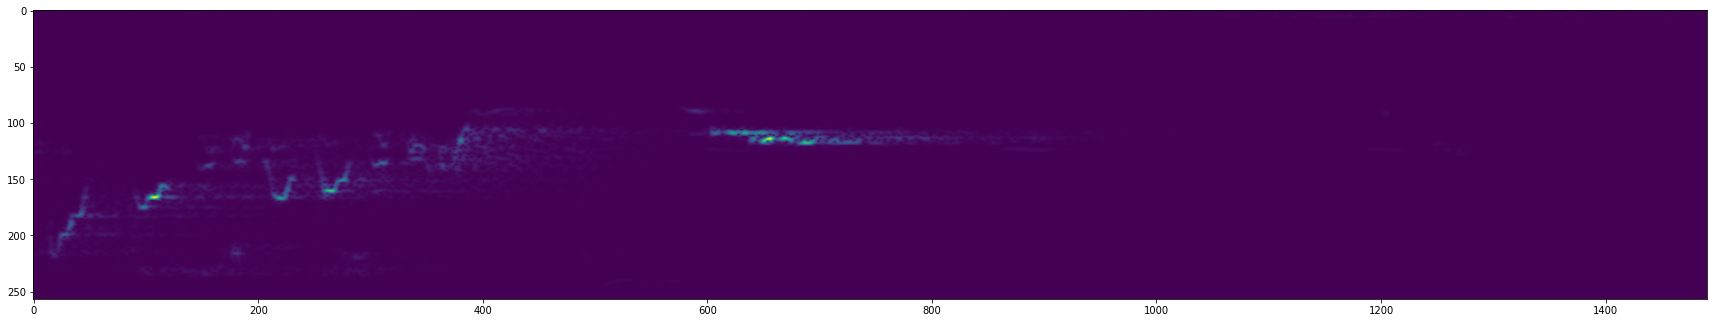

In [21]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

# 6.1 Create a Tensorflow Data Pipeline

In [22]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(10)
data = data.prefetch(8)

# 6.2 Split into Training and Testing Partitions

In [23]:
train = data.take(36)
test = data.skip(36).take(15)

# 6.3 Test One Batch

In [24]:
samples, labels = train.as_numpy_iterator().next()

In [25]:
samples.shape

(10, 1491, 257, 1)

# 7. Build Deep Learning Model

# 7.1 Load Tensorflow Dependencies

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

# 7.2 Build Sequential Model, Compile and View Summary

In [27]:
model = Sequential()
model.add(Conv2D(10, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(10, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 10)     100       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 10)     910       
                                                                 
 flatten (Flatten)           (None, 3762110)           0         
                                                                 
 dense (Dense)               (None, 128)               481550208 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 481,551,347
Trainable params: 481,551,347
Non-trainable params: 0
_________________________________________________________________


# 7.3 Fit Model, View Loss and KPI Plots

In [30]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 19s 199ms/step - loss: 4.3956 - recall: 0.8571 - precision: 0.8125 - val_loss: 0.5115 - val_recall: 0.9048 - val_precision: 0.9500
Epoch 2/4
36/36 [==============================] - 7s 190ms/step - loss: 0.1926 - recall: 0.9583 - precision: 0.9583 - val_loss: 0.7931 - val_recall: 0.9189 - val_precision: 0.9714
Epoch 3/4
36/36 [==============================] - 7s 190ms/step - loss: 0.2927 - recall: 0.9438 - precision: 0.9767 - val_loss: 0.0190 - val_recall: 0.9487 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 7s 191ms/step - loss: 0.0247 - recall: 0.9899 - precision: 0.9800 - val_loss: 0.0027 - val_recall: 1.0000 - val_precision: 1.0000


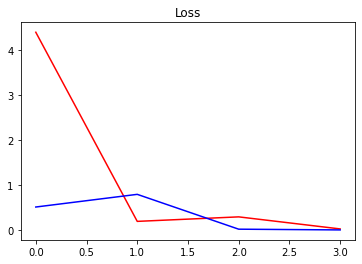

In [31]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

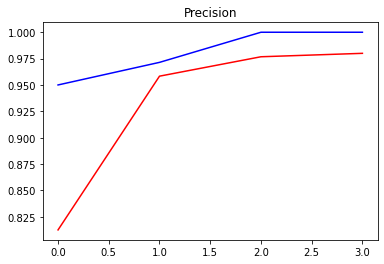

In [32]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()


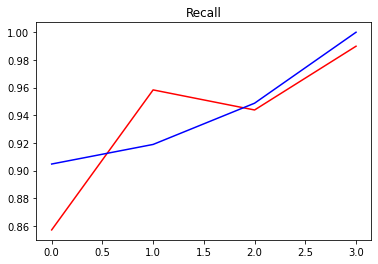

In [33]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip
# 8.1 Get One Batch and Make a Prediction

In [42]:
X_test, y_test = test.as_numpy_iterator().next()

In [43]:
yhat = model.predict(X_test)

In [44]:
yhat

array([[1.2843228e-03],
       [1.0000000e+00],
       [1.0000000e+00],
       [5.2889717e-01],
       [6.5624465e-07],
       [3.0177107e-25],
       [6.6089799e-12],
       [1.2480835e-26],
       [4.1673850e-10],
       [9.4474830e-34]], dtype=float32)

# 8.2 Convert Logits to Classes


In [45]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

Compare the clasess

In [46]:
yhat

[0, 1, 1, 1, 0, 0, 0, 0, 0, 0]

In [47]:
y_test.astype(int)

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [48]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In [49]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=3.0>

# 9. Build Forest Parsing Functions
# 9.1 Load up MP3s

In [50]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [51]:
mp3 = os.path.join("/content/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings/recording_00.mp3")

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [53]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)


- What we've done that we tooked a one full mp3 file and convert it to 60 window
- We gonna take those windows and convert it to spectograme and loop through them all and make predictions

In [ ]:
len(audio_slices)

In [54]:
samples, index = audio_slices.as_numpy_iterator().next()

In [55]:
samples.shape

(1, 48000)

# 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [56]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

# 9.3 Convert Longer Clips into Windows and Make Predictions

In [60]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [67]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

In [68]:
len(yhat)

60

# 9.4 Group Consecutive Detections


In [69]:
from itertools import groupby

In [70]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [71]:
calls

5

# 10. Make Predictions
# 10.1 Loop over all recordings and make predictions

In [ ]:
results = {}
for file in os.listdir(os.path.join("/content/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings")):
    FILEPATH = os.path.join("/content/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings", file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat


In [ ]:
results

# 10.2 Convert Predictions into Classes

In [75]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]


# 10.3 Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

# 11. Export Results

In [76]:
import csv
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])